# COMP579 Assignment 2

**Coding: Tabular RL [70 points]**

In [1]:
!pip install renderlab
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 17.8 MB/s eta 0:00:00


In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import renderlab as rl

In [3]:
def softmax(qValues, temp):
  eQdivT = np.exp((qValues - np.max(qValues)) / temp)
  probabilities = eQdivT / eQdivT.sum(axis=0) #division will be element wise
  return probabilities

In [34]:
class Sarsa:
  def __init__(self, env, alpha, gamma, temp):
    self.env = env
    self.alpha = alpha
    self.gamma = gamma
    self.temp = temp
    self.Q = np.zeros((env.observation_space.n, env.action_space.n))

  # resets the class for multiple trials
  def reset(self):
    self.Q = np.zeros((env.observation_space.n, env.action_space.n))


  def select_action(self, s, greedy=False):
    if greedy:
      # if finished training, then choose the optimal policy
      action = np.argmax(self.Q[s])
      return action
    else:
      probOfActions = softmax(self.Q[s], self.temp)
      choiceList = np.arange(len(probOfActions))
      randAction = np.random.choice(choiceList, p=probOfActions)
      return randAction

  def update(self, s, a, r, s_prime, a_prime, done):
    if done:
      bootStrappedQ = 0
    else:
      bootStrappedQ = self.Q[s_prime, a_prime]

    gain = r + self.gamma * bootStrappedQ

    self.Q[s, a] += self.alpha * (gain - self.Q[s, a])


class ExpectedSarsa:
  def __init__(self, env, alpha, gamma, temp):
    self.env = env
    self.alpha = alpha
    self.gamma = gamma
    self.temp = temp
    self.Q = np.zeros((env.observation_space.n, env.action_space.n))

  # resets the class for multiple trials
  def reset(self):
    self.Q = np.zeros((env.observation_space.n, env.action_space.n))

  def select_action(self, s, greedy=False):
    if greedy:
      # if finished training, then choose the optimal policy
      return np.argmax(self.Q[s])
    else:
      probOfActions = softmax(self.Q[s], self.temp)
      choiceList = np.arange(len(probOfActions))
      randAction = np.random.choice(choiceList, p=probOfActions)
      return randAction

  def update(self, s, a, r, s_prime, a_prime, done):
    if done:
      expectedQnext = 0
    else:
      probOfActions = softmax(self.Q[s_prime], self.temp)
      expectedQnext = np.sum(self.Q[s_prime] * probOfActions)

    TDtarget = r + self.gamma * expectedQnext
    TDerror = TDtarget - self.Q[s, a]
    self.Q[s, a] += self.alpha * TDerror


# bonus question, optional
class Hybrid_Sarsa_Q:
    def __init__(self, env, alpha, gamma, epsilon):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = np.zeros((env.observation_space.n, env.action_space.n))

    def reset(self):
        self.Q = np.zeros((self.env.observation_space.n, self.env.action_space.n))

    def select_action(self, s, greedy=False):
        if greedy or np.random.rand() > self.epsilon:
            return np.argmax(self.Q[s])
        else:
            return self.env.action_space.sample()

    def get_epsilon_greedy_probs(self, s):
        action_probs = np.ones(self.env.action_space.n) * self.epsilon / self.env.action_space.n
        best_action = np.argmax(self.Q[s])
        action_probs[best_action] += (1.0 - self.epsilon)
        return action_probs

    def update(self, s, a, r, s_prime, a_prime, done):
        max_q_s_prime = np.max(self.Q[s_prime])
        epsilon_greedy_probs = self.get_epsilon_greedy_probs(s_prime)
        expected_q_s_prime = np.sum(self.Q[s_prime] * epsilon_greedy_probs)

        if not done:
            TD_target = r + self.gamma * ((1 - self.alpha) * max_q_s_prime + self.alpha * expected_q_s_prime)
        else:
            TD_target = r

        TD_error = TD_target - self.Q[s, a]
        self.Q[s, a] += self.alpha * TD_error




# Write your experiment code below

In [5]:
env_name = 'Taxi-v3'
env = gym.make(env_name)
print("Action space:", env.action_space)
print("State space:", env.observation_space)

Action space: Discrete(6)
State space: Discrete(500)


In [6]:
# function that runs each episode, returns final training performance
def run_trial(alg, env, segments=500, episodes=10, test_episodes=1, verbose=False):
    #returns total reward per episode
    train_data = []
    test_data = []

    for seg in range(segments):
        seg_train_data = []
        seg_test_data = []
        for ep in range(episodes):
            ep_reward = 0
            state = env.reset()[0]
            action = alg.select_action(state)

            done = False
            while not done:
                next_state, reward, terminated, truncated, info = env.step(action)
                done = truncated or terminated
                next_action = alg.select_action(next_state, greedy=False)
                alg.update(state, action, reward, next_state, next_action, done)
                state = next_state
                action = next_action
                ep_reward += reward

            seg_train_data += [ep_reward]
        train_data += [seg_train_data]

        for ep in range(test_episodes):
            ep_reward = 0
            state = env.reset()[0]
            action = alg.select_action(state, greedy=True)

            done = False
            while not done:
                next_state, reward, terminated, truncated, info = env.step(action)
                done = truncated or terminated
                next_action = alg.select_action(next_state, greedy=True)
                state = next_state
                action = next_action
                ep_reward += reward

            seg_test_data += [ep_reward]
        test_data += [seg_test_data]

        #debug
        if verbose:
          print(f'{seg} train, {np.mean(seg_train_data)}, test, {seg_test_data[0]}')

    return (train_data, test_data)


In [7]:
#testing with a single trial
algorithm = ExpectedSarsa(env, alpha=0.1, gamma=0.99, temp=0.005)
train, test = run_trial(alg=algorithm, env=env, segments=500, verbose=True)

0 train, -621.1, test, -200
1 train, -454.7, test, -200
2 train, -321.4, test, -200
3 train, -279.6, test, -200
4 train, -226.5, test, -200
5 train, -186.5, test, -200
6 train, -295.8, test, -200
7 train, -266.6, test, -200
8 train, -264.5, test, -200
9 train, -260.3, test, -200
10 train, -286.8, test, -200
11 train, -225.0, test, -200
12 train, -208.3, test, -200
13 train, -224.1, test, -200
14 train, -168.6, test, -200
15 train, -228.3, test, -200
16 train, -236.7, test, -200
17 train, -214.2, test, -200
18 train, -176.5, test, -200
19 train, -177.8, test, -200
20 train, -200.8, test, -200
21 train, -203.1, test, -200
22 train, -192.3, test, -200
23 train, -158.3, test, -200
24 train, -214.4, test, -1991
25 train, -97.9, test, -200
26 train, -197.4, test, -200
27 train, -171.0, test, -200
28 train, -132.3, test, -200
29 train, -169.7, test, -200
30 train, -135.3, test, -2000
31 train, -136.7, test, -200
32 train, -103.9, test, -200
33 train, -169.0, test, -200
34 train, -108.4, test,

In [8]:
def get_final_train_test_performance(train_data, test_data):
    return np.mean(train_data[-1]), np.mean(test_data[-1])

In [9]:
print(get_final_train_test_performance(train, test))

(7.1, 4.0)


In [10]:
#returns final performance for train and test over multiple trials
def run_multiple(alg, env, alpha, gamma, temp, num_trials=10, verbose=False):
    train = []
    test = []
    for i in range(num_trials):
        if verbose:
            print(f'Running Trial #{i}')
        alg.reset()
        train_data, test_data = run_trial(alg, env, verbose=verbose)
        strain, stest = get_final_train_test_performance(train_data, test_data)
        train += [strain]
        test += [stest]
    return train, test

In [11]:
algorithm = Sarsa(env, alpha=0.1, gamma=0.9, temp=0.05)
train, test = run_multiple(algorithm, env, alpha=0.1, gamma=0.9, temp=0.05, verbose=True)

Streaming output truncated to the last 5000 lines.
9 train, -204.2, test, -1973
10 train, -279.3, test, -200
11 train, -188.1, test, -200
12 train, -195.0, test, -200
13 train, -237.7, test, -200
14 train, -201.0, test, -200
15 train, -238.9, test, -200
16 train, -184.7, test, -200
17 train, -206.3, test, -200
18 train, -190.9, test, -200
19 train, -154.3, test, -200
20 train, -171.8, test, -200
21 train, -208.4, test, -200
22 train, -156.9, test, -200
23 train, -221.9, test, -200
24 train, -139.0, test, -200
25 train, -185.5, test, -200
26 train, -185.0, test, -200
27 train, -135.7, test, -200
28 train, -181.2, test, -200
29 train, -166.8, test, -200
30 train, -150.8, test, -200
31 train, -131.4, test, -200
32 train, -142.9, test, -200
33 train, -164.4, test, -200
34 train, -101.0, test, -200
35 train, -138.0, test, -200
36 train, -123.6, test, -1991
37 train, -107.4, test, -200
38 train, -104.9, test, -200
39 train, -97.9, test, -200
40 train, -102.5, test, -200
41 train, -64.8, test

In [12]:
#hyperparameters to test
alphas = [0.1, 0.4, 0.6, 0.9]
gammas = [0.99]
temps = [0.01, 0.05, 0.1]

In [13]:
print(train)
print(test)

[8.7, 9.0, 8.5, 7.8, 8.2, 6.7, 6.2, 7.8, 9.0, 7.3]
[4.0, 6.0, 5.0, 5.0, 7.0, 12.0, 6.0, 10.0, 6.0, 11.0]


In [14]:
#running all trials for all hyperparameter combinations for sarsa
final_train_sarsa = [[[[] for x in range(len(temps))]for x in range(len(gammas))] for x in range(len(alphas))]
final_test_sarsa = [[[[] for x in range(len(temps))]for x in range(len(gammas))] for x in range(len(alphas))]

for i in range(len(alphas)):
  for j in range(len(gammas)):
    for k in range(len(temps)):
      print(f'Running alpha = {alphas[i]}, gamma = {gammas[j]}, temp = {temps[k]}')
      algorithm = Sarsa(env, alphas[i], gammas[j], temps[k])
      train, test = run_multiple(algorithm, env, alphas[i], gammas[j], temps[k])
      final_train_sarsa[i][j][k] = train
      final_test_sarsa[i][j][k] = test

Running alpha = 0.1, gamma = 0.99, temp = 0.01
Running alpha = 0.1, gamma = 0.99, temp = 0.05
Running alpha = 0.1, gamma = 0.99, temp = 0.1
Running alpha = 0.4, gamma = 0.99, temp = 0.01
Running alpha = 0.4, gamma = 0.99, temp = 0.05
Running alpha = 0.4, gamma = 0.99, temp = 0.1
Running alpha = 0.6, gamma = 0.99, temp = 0.01
Running alpha = 0.6, gamma = 0.99, temp = 0.05
Running alpha = 0.6, gamma = 0.99, temp = 0.1
Running alpha = 0.9, gamma = 0.99, temp = 0.01
Running alpha = 0.9, gamma = 0.99, temp = 0.05
Running alpha = 0.9, gamma = 0.99, temp = 0.1


In [15]:
# extra_train = []
# extra_test = []
# for k in range(len(temps)):
#     algorithm = ExpectedSarsa(env, alpha=0.9, gamma=0.99, temp=temps[k])
#     train, test = run_multiple(algorithm, env, alpha=0.9, gamma=0.99, temp=temps[k])
#     extra_train.append(train)
#     extra_test.append(test)

# extra_train = [extra_train]
# extra_test = [extra_test]

# final_train_expsarsa.append(extra_train)
# final_test_expsarsa.append(extra_test)

In [16]:
print(final_test_sarsa)

[[[[8.0, 7.0, 8.0, 12.0, 10.0, 10.0, 7.0, 7.0, 7.0, 13.0], [10.0, 7.0, 8.0, 8.0, 8.0, 14.0, 11.0, 5.0, 9.0, 11.0], [6.0, 9.0, 12.0, 9.0, 9.0, 5.0, 7.0, 14.0, 5.0, 10.0]]], [[[9.0, 6.0, 11.0, 11.0, 5.0, 7.0, 5.0, 12.0, 9.0, 11.0], [6.0, 5.0, 12.0, 7.0, 6.0, 8.0, 11.0, 11.0, 5.0, 4.0], [7.0, 5.0, 7.0, 11.0, 5.0, 6.0, 6.0, 9.0, 10.0, 10.0]]], [[[6.0, 14.0, 5.0, 7.0, 7.0, 10.0, 9.0, 11.0, 8.0, 6.0], [8.0, 8.0, 7.0, 8.0, 6.0, 10.0, 6.0, 10.0, 9.0, 4.0], [8.0, 6.0, 5.0, 5.0, 7.0, 9.0, 4.0, 8.0, 7.0, 10.0]]], [[[8.0, 7.0, 4.0, 7.0, 7.0, 10.0, 6.0, 3.0, 8.0, 10.0], [10.0, 9.0, 4.0, 7.0, 13.0, 6.0, 5.0, 10.0, 7.0, 11.0], [4.0, 11.0, 7.0, 12.0, 7.0, 10.0, 4.0, 4.0, 9.0, 11.0]]]]


In [17]:
#running all trials for all hyperparameter combinations for expected sarsa
final_train_expsarsa = [[[[] for x in range(len(temps))]for x in range(len(gammas))] for x in range(len(alphas))]
final_test_expsarsa = [[[[] for x in range(len(temps))]for x in range(len(gammas))] for x in range(len(alphas))]

for i in range(len(alphas)):
  for j in range(len(gammas)):
    for k in range(len(temps)):
      print(f'Running alpha = {alphas[i]}, gamma = {gammas[j]}, temp = {temps[k]}')
      algorithm = ExpectedSarsa(env, alphas[i], gammas[j], temps[k])
      train, test = run_multiple(algorithm, env, alphas[i], gammas[j], temps[k])
      final_train_expsarsa[i][j][k] = train
      final_test_expsarsa[i][j][k] = test

Running alpha = 0.1, gamma = 0.99, temp = 0.01
Running alpha = 0.1, gamma = 0.99, temp = 0.05
Running alpha = 0.1, gamma = 0.99, temp = 0.1
Running alpha = 0.4, gamma = 0.99, temp = 0.01
Running alpha = 0.4, gamma = 0.99, temp = 0.05
Running alpha = 0.4, gamma = 0.99, temp = 0.1
Running alpha = 0.6, gamma = 0.99, temp = 0.01
Running alpha = 0.6, gamma = 0.99, temp = 0.05
Running alpha = 0.6, gamma = 0.99, temp = 0.1
Running alpha = 0.9, gamma = 0.99, temp = 0.01
Running alpha = 0.9, gamma = 0.99, temp = 0.05
Running alpha = 0.9, gamma = 0.99, temp = 0.1


In [ ]:
#create training plot for SARSA TRAIN
# final data in the form 4x1x3x10 for training, 4x1x3x10 for testing

#3x10
sarsa_train_temp1 = []
sarsa_train_temp2 = []
sarsa_train_temp3 = []

gamma_index = 0

alphas = [0.01, 0.1, 0.5, 0.9]

#first isolate and get points for varying temps, 3 lines
for i in range(len(alphas)):
    sarsa_train_temp1.append(final_train_sarsa[i][gamma_index][0])
    sarsa_train_temp2.append(final_train_sarsa[i][gamma_index][1])
    sarsa_train_temp3.append(final_train_sarsa[i][gamma_index][2])

#for a 3x10 array
def get_mean_min_max(data):
    return [[np.mean(x), np.min(x), np.max(x)] for x in data]

#3x3x10
sarsa_train = [sarsa_train_temp1, sarsa_train_temp2, sarsa_train_temp3]

#3x3x3
for i in range(len(sarsa_train)):
    sarsa_train[i] = get_mean_min_max(sarsa_train[i])

#3x3
sarsa_train_mean = [[x[0] for x in y] for y in sarsa_train]
sarsa_train_min = [[x[1] for x in y] for y in sarsa_train]
sarsa_train_max = [[x[2] for x in y] for y in sarsa_train]

In [ ]:
#create training plot for SARSA TEST
# final data in the form 4x1x3x10 for training, 4x1x3x10 for testing

#3x10
sarsa_test_temp1 = []
sarsa_test_temp2 = []
sarsa_test_temp3 = []

gamma_index = 0

alphas = [0.01, 0.1, 0.5, 0.9]

#first isolate and get points for varying temps, 3 lines
for i in range(len(alphas)):
    sarsa_test_temp1.append(final_test_sarsa[i][gamma_index][0])
    sarsa_test_temp2.append(final_test_sarsa[i][gamma_index][1])
    sarsa_test_temp3.append(final_test_sarsa[i][gamma_index][2])

#for a 3x10 array
def get_mean_min_max(data):
    return [[np.mean(x), np.min(x), np.max(x)] for x in data]

#3x3x10
sarsa_test = [sarsa_test_temp1, sarsa_test_temp2, sarsa_test_temp3]

#3x3x3
for i in range(len(sarsa_test)):
    sarsa_test[i] = get_mean_min_max(sarsa_test[i])

#3x3
sarsa_test_mean = [[x[0] for x in y] for y in sarsa_test]
sarsa_test_min = [[x[1] for x in y] for y in sarsa_test]
sarsa_test_max = [[x[2] for x in y] for y in sarsa_test]

In [26]:
#create training plot for EXP SARSA TRAIN
# final data in the form 4x1x3x10 for training, 4x1x3x10 for testing

#3x10
expsarsa_train_temp1 = []
expsarsa_train_temp2 = []
expsarsa_train_temp3 = []

gamma_index = 0

alphas = [0.01, 0.1, 0.5, 0.9]

#first isolate and get points for varying temps, 3 lines
for i in range(len(alphas)):
    expsarsa_train_temp1.append(final_train_expsarsa[i][gamma_index][0])
    expsarsa_train_temp2.append(final_train_expsarsa[i][gamma_index][1])
    expsarsa_train_temp3.append(final_train_expsarsa[i][gamma_index][2])

#for a 3x10 array
def get_mean_min_max(data):
    return [[np.mean(x), np.min(x), np.max(x)] for x in data]

#4x3x10
expsarsa_train = [expsarsa_train_temp1, expsarsa_train_temp2, expsarsa_train_temp3]

#4x3x3
for i in range(len(expsarsa_train)):
    expsarsa_train[i] = get_mean_min_max(expsarsa_train[i])

#4x3
expsarsa_train_mean = [[x[0] for x in y] for y in expsarsa_train]
expsarsa_train_min = [[x[1] for x in y] for y in expsarsa_train]
expsarsa_train_max = [[x[2] for x in y] for y in expsarsa_train]

In [27]:
#create training plot for EXP SARSA TEST
# final data in the form 4x1x3x10 for training, 4x1x3x10 for testing

#3x10
expsarsa_test_temp1 = []
expsarsa_test_temp2 = []
expsarsa_test_temp3 = []

gamma_index = 0

alphas = [0.01, 0.1, 0.5, 0.9]

#first isolate and get points for varying temps, 3 lines
for i in range(len(alphas)):
    expsarsa_test_temp1.append(final_test_expsarsa[i][gamma_index][0])
    expsarsa_test_temp2.append(final_test_expsarsa[i][gamma_index][1])
    expsarsa_test_temp3.append(final_test_expsarsa[i][gamma_index][2])

#for a 3x10 array
def get_mean_min_max(data):
    return [[np.mean(x), np.min(x), np.max(x)] for x in data]

#4x3x10
expsarsa_test = [expsarsa_test_temp1, expsarsa_test_temp2, expsarsa_test_temp3]

#4x3x3
for i in range(len(expsarsa_test)):
    expsarsa_test[i] = get_mean_min_max(expsarsa_test[i])

#4x3
expsarsa_test_mean = [[x[0] for x in y] for y in expsarsa_test]
expsarsa_test_min = [[x[1] for x in y] for y in expsarsa_test]
expsarsa_test_max = [[x[2] for x in y] for y in expsarsa_test]

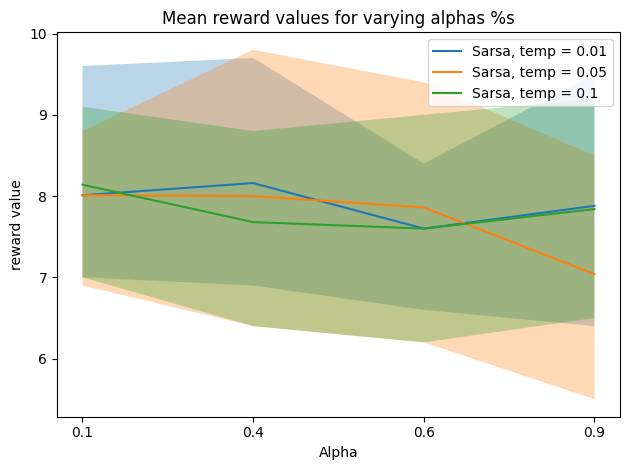

In [29]:
#SARSA TRAIN
alphas_tick = [0.1, 0.4, 0.6, 0.9]
fig, ax = plt.subplots()

for i in range(len(temps)):
  x_indices = range(len(alphas_tick))
  plt_temp, = ax.plot(x_indices, sarsa_train_mean[i], label = f"Sarsa, temp = {temps[i]}")
  # draw the error bar/area for averaging
  plt_temp_minus = sarsa_train_min[i]
  plt_temp_plus = sarsa_train_max[i]
  ax.fill_between(range(0,4), plt_temp_minus, plt_temp_plus, alpha=0.3)

plt.xticks(x_indices, alphas_tick)
ax.set_xlabel("Alpha")
ax.set_ylabel("reward value")
ax.set_title("Mean reward values for varying alphas %s")

ax.legend()
plt.tight_layout()
plt.show()

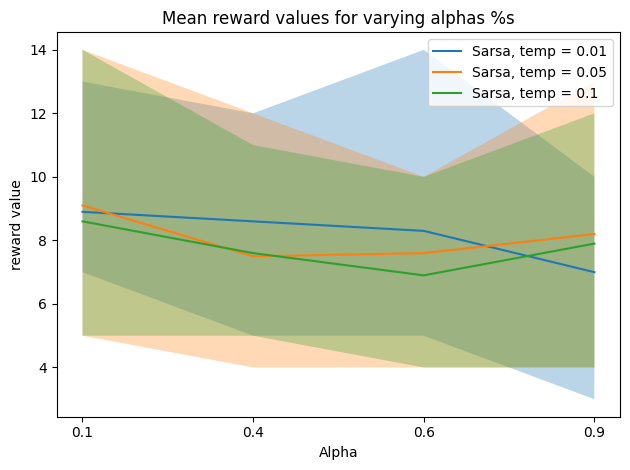

In [31]:
#SARSA TEST
alphas_tick = [0.1, 0.4, 0.6, 0.9]
fig, ax = plt.subplots()

for i in range(len(temps)):
  x_indices = range(len(alphas_tick))
  plt_temp, = ax.plot(x_indices, sarsa_test_mean[i], label = f"Sarsa, temp = {temps[i]}")
  # draw the error bar/area for averaging
  plt_temp_minus = sarsa_test_min[i]
  plt_temp_plus = sarsa_test_max[i]
  ax.fill_between(range(0,4), plt_temp_minus, plt_temp_plus, alpha=0.3)

plt.xticks(x_indices, alphas_tick)
ax.set_xlabel("Alpha")
ax.set_ylabel("reward value")
ax.set_title("Mean reward values for varying alphas %s")

ax.legend()
plt.tight_layout()
plt.show()

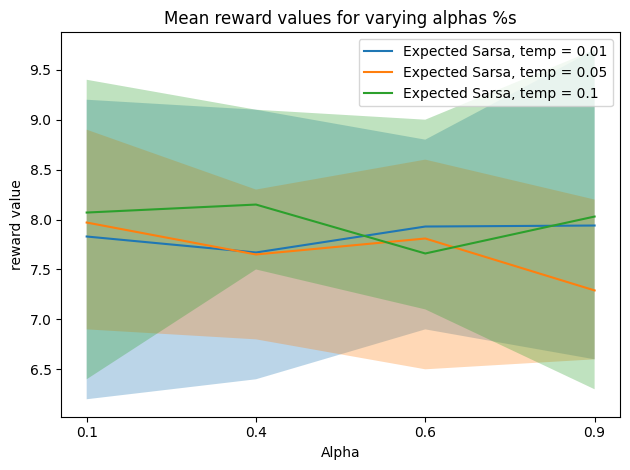

In [32]:
#EXP SARSA TRAIN
alphas_tick = [0.1, 0.4, 0.6, 0.9]
fig, ax = plt.subplots()

for i in range(len(temps)):
  x_indices = range(len(alphas_tick))
  plt_temp, = ax.plot(x_indices, expsarsa_train_mean[i], label = f"Expected Sarsa, temp = {temps[i]}")
  # draw the error bar/area for averaging
  plt_temp_minus = expsarsa_train_min[i]
  plt_temp_plus = expsarsa_train_max[i]
  ax.fill_between(range(0,4), plt_temp_minus, plt_temp_plus, alpha=0.3)


plt.xticks(x_indices, alphas_tick)
ax.set_xlabel("Alpha")
ax.set_ylabel("reward value")
ax.set_title("Mean reward values for varying alphas %s")

ax.legend()
plt.tight_layout()
plt.show()

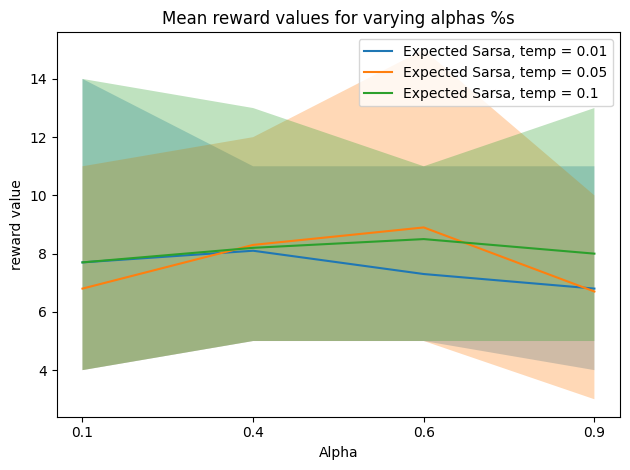

In [33]:
#EXP SARSA TRAIN
alphas_tick = [0.1, 0.4, 0.6, 0.9]
fig, ax = plt.subplots()

for i in range(len(temps)):
  x_indices = range(len(alphas_tick))
  plt_temp, = ax.plot(x_indices, expsarsa_test_mean[i], label = f"Expected Sarsa, temp = {temps[i]}")
  # draw the error bar/area for averaging
  plt_temp_minus = expsarsa_test_min[i]
  plt_temp_plus = expsarsa_test_max[i]
  ax.fill_between(range(0,4), plt_temp_minus, plt_temp_plus, alpha=0.3)


plt.xticks(x_indices, alphas_tick)
ax.set_xlabel("Alpha")
ax.set_ylabel("reward value")
ax.set_title("Mean reward values for varying alphas %s")

ax.legend()
plt.tight_layout()
plt.show()

In [35]:
#running all trials for all hyperparameter combinations for hybrid
final_train_hybsarsa = [[[[] for x in range(len(temps))]for x in range(len(gammas))] for x in range(len(alphas))]
final_test_hybsarsa = [[[[] for x in range(len(temps))]for x in range(len(gammas))] for x in range(len(alphas))]

for i in range(len(alphas)):
  for j in range(len(gammas)):
    for k in range(len(temps)):
      print(f'Running alpha = {alphas[i]}, gamma = {gammas[j]}, temp = {temps[k]}')
      algorithm = Hybrid_Sarsa_Q(env, alphas[i], gammas[j], temps[k])
      train, test = run_multiple(algorithm, env, alphas[i], gammas[j], temps[k])
      final_train_hybsarsa[i][j][k] = train
      final_test_hybsarsa[i][j][k] = test

Running alpha = 0.01, gamma = 0.99, temp = 0.01
Running alpha = 0.01, gamma = 0.99, temp = 0.05
Running alpha = 0.01, gamma = 0.99, temp = 0.1
Running alpha = 0.1, gamma = 0.99, temp = 0.01
Running alpha = 0.1, gamma = 0.99, temp = 0.05
Running alpha = 0.1, gamma = 0.99, temp = 0.1
Running alpha = 0.5, gamma = 0.99, temp = 0.01
Running alpha = 0.5, gamma = 0.99, temp = 0.05
Running alpha = 0.5, gamma = 0.99, temp = 0.1
Running alpha = 0.9, gamma = 0.99, temp = 0.01
Running alpha = 0.9, gamma = 0.99, temp = 0.05
Running alpha = 0.9, gamma = 0.99, temp = 0.1


In [52]:
#create training plot for EXP SARSA TEST
# final data in the form 4x1x3x10 for training, 4x1x3x10 for testing

#3x10
hybsarsa_test_temp1 = []
hybsarsa_test_temp2 = []
hybsarsa_test_temp3 = []

gamma_index = 0

alphas = [0.1, 0.4, 0.6, 0.9]

#first isolate and get points for varying temps, 3 lines
for i in range(1, len(alphas)):
    hybsarsa_test_temp1.append(final_test_hybsarsa[i][gamma_index][0])
    hybsarsa_test_temp2.append(final_test_hybsarsa[i][gamma_index][1])
    hybsarsa_test_temp3.append(final_test_hybsarsa[i][gamma_index][2])

#for a 3x10 array
def get_mean_min_max(data):
    return [[np.mean(x), np.min(x), np.max(x)] for x in data]

#4x3x10
hybsarsa_test = [hybsarsa_test_temp1, hybsarsa_test_temp2, hybsarsa_test_temp3]

#4x3x3
for i in range(len(hybsarsa_test)):
    hybsarsa_test[i] = get_mean_min_max(hybsarsa_test[i])

#4x3
hybsarsa_test_mean = [[x[0] for x in y] for y in hybsarsa_test]
hybsarsa_test_min = [[x[1] for x in y] for y in hybsarsa_test]
hybsarsa_test_max = [[x[2] for x in y] for y in hybsarsa_test]

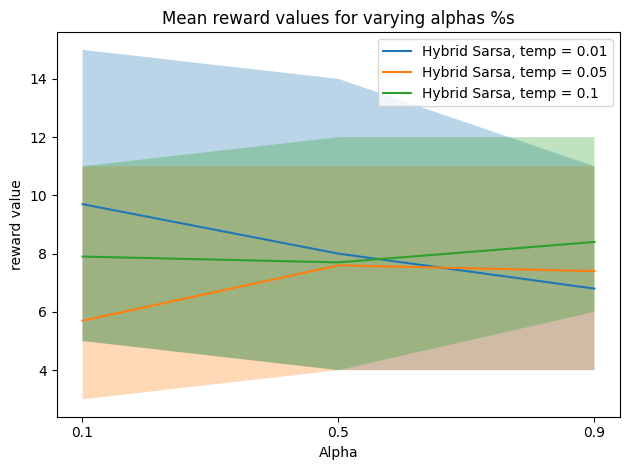

In [59]:
#HYB SARSA TRAIN
alphas_tick = alphas = [0.1, 0.5, 0.9]
fig, ax = plt.subplots()

for i in range(len(temps)):
  x_indices = range(len(alphas_tick))
  plt_temp, = ax.plot(x_indices, hybsarsa_test_mean[i], label = f"Hybrid Sarsa, temp = {temps[i]}")
  # draw the error bar/area for averaging
  plt_temp_minus = hybsarsa_test_min[i]
  plt_temp_plus = hybsarsa_test_max[i]
  ax.fill_between(range(0,3), plt_temp_minus, plt_temp_plus, alpha=0.3)


plt.xticks(x_indices, alphas_tick)
ax.set_xlabel("Alpha")
ax.set_ylabel("reward value")
ax.set_title("Mean reward values for varying alphas %s")

ax.legend()
plt.tight_layout()
plt.show()